In [1]:
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-h009bvqe
     |████████████████████████████████| 50 kB 806 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=017354ce48eef9079cfb47adc0267ce33e7d062d9834dfe783e6bffb075c78e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-uflklnys/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


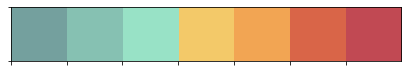

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
import tensorflow.keras.applications as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns
from sklearn import preprocessing


pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

defining number of epochs in training (i think its the number of epoch(num rounds of looping through the entire dataset) for training train data from each fold)
defining batch_size (how many training examples to feed into network before updating the weights and internal nodes)
LR: learning rate
model_class allow us to define which efficientnet model we want to use


In [3]:
EPOCHS = 100
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression/'

Splitting data into train and test set (our own private test set)

In [4]:
#reading in data
all_data = pd.read_csv(f'{path}/train.csv')

all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)


train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

In [5]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [6]:
def get_baseline_FVC_new(df):
    _df = (
        df
        .loc[df.Weeks == df.min_week][['Patient','FVC']]
        .rename({'FVC': 'base_FVC'}, axis=1)
        .groupby('Patient')
        .first()
        .reset_index()
    )
    df_new = df.merge(_df, on = 'Patient', how = 'left') 
    
    return df_new

In [7]:
def own_OneHotColumnCreator(df, columns):
    """OneHot Encodes categorical features. Adds a column for each unique value per column"""
    for col in cat_attribs:
        for value in df[col].unique():
            df[value] = (df[col] == value).astype(int)

In [8]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [9]:
train = get_baseline_week(train)
train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
test = get_baseline_FVC_new(test)


In [10]:
num_attribs_scld = [s + '_scld' for s in num_attribs]
min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.fit_transform(test[num_attribs])

In [11]:
own_OneHotColumnCreator(train, cat_attribs)
own_OneHotColumnCreator(test, cat_attribs)

In [12]:
train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,base_FVC,Percent_scld,Age_scld,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,2315,0.202489,0.789474,1,0,1,0,0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,2315,0.181129,0.789474,1,0,1,0,0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,2315,0.148772,0.789474,1,0,1,0,0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,2315,0.166325,0.789474,1,0,1,0,0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,2315,0.150464,0.789474,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked,0,13,2925,0.272591,0.631579,1,0,0,1,0
1219,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked,0,19,2925,0.327486,0.631579,1,0,0,1,0
1220,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked,0,31,2925,0.313040,0.631579,1,0,0,1,0
1221,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked,0,43,2925,0.326867,0.631579,1,0,0,1,0


get_tab allows us to frame each patients metadata (age, sex, smoking status) into a np array

In [13]:
def get_tab_scaled(df): #getting scaled variables #input only one patient's df #get columns needed --> return the entire df with only desired columns
    #df_elements = df1.sample(n=1)
    df['bias'] = 0 #adding a bias term
    df1 = df[['bias', 'baselined_week', 'base_FVC', 'Percent_scld', 'Age_scld', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'FVC']]
    lis = df1.loc[:].values.tolist()
    return lis

In [14]:
#A = {} # The gradient
TAB = {} # Tabular data for each patient
P = [] # Patient IDs
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] #get only the part of df belonging to patient p
    patient_arr = get_tab_scaled(sub) #get only the part of data we want; 2D array with every row of pdata
    TAB[p] = patient_arr #add the entire patient_arr (2D) to patient id in dictionary
    P.append(p) #add the patientID into a list

In [15]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

In [16]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 #1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        tab = [] 
        f = []
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                meta = self.tab[k]
                to_append_meta = random.choice(meta)
                tab.append(to_append_meta[:-1]) #append meta data
                f.append(to_append_meta[-1]) #append fvc of same patient
            except:
                print(k, i)
       
        x,f,tab = np.array(x), np.array(f), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , f

In [17]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(10,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [18]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", #val_loss
        min_delta=1e-3,
        patience=50,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', #val_loss
        factor=0.75,
        patience=10, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

#####################
####### Fold 0 ######
#####################
Training...
Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 7089042.5000
Epoch 00001: val_loss improved from inf to 6658098.50000, saving model to fold-0.h5
32/32 [==============================] - 19s 602ms/step - loss: 7089042.5000 - val_loss: 6658098.5000
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 6152898.5000
Epoch 00002: val_loss did not improve from 6658098.50000
32/32 [==============================] - 15s 466ms/step - loss: 6152898.5000 - val_loss: 9447896064.0000
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 4849973.5000
Epoch 00003: val_loss did not improve from 6658098.50000
32/32 [==============================] - 15s 463ms/step - loss: 4849973.5000 - val_loss: 407384850432.0000
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 3740127.7500
Epoch 00004: val_loss did not improve from 6658098.50000
32/32 [==================

In [19]:
min_array = []
for i in range(1):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

0 344798.3125
344798.3125


In [20]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

Our mean CV MAE is: 395306.21875


min_fold finds out which fold gives the least validation loss

In [21]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [22]:
#min_fold = 1

building model for prediction

In [23]:
def build_pred_model(shape=(512, 512, 1), model_class=None, fold=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(10,)) #change the num of nodes when we add new features
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('./') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('./' + weights) #use dir of './' if using training above, e
    #weights = [w for w in os.listdir('../input/predict-fvc-direct-100epochs/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/predict-fvc-direct-100epochs/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]

In [24]:
def process_test_data(test_id, test):
    final_test_data = []
    sub = test.loc[test.Patient == test_id, :]
    sub['bias'] = 0
    sub['mean_percent_scld'] = sub['Percent_scld'].mean()
    selected_sub = sub[['bias', 'baselined_week', 'base_FVC', 'mean_percent_scld', 'Age_scld', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes']]
    #get first row 
    selected_sub.reindex()
    first = selected_sub.iloc[0].values.tolist()
    for week in range(0, 146):
        to_append = copy.deepcopy(first)
        to_append[1] = week
        final_test_data.append(to_append)
    return final_test_data

In [25]:
subs = [] 
q = 0.5
#weeks = list(range(-12, 134))
predictions = []
for model in models:
    
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        data_to_be_fed = process_test_data(p, test.loc[test.Patient == p, :])
        for i in range(len(data_to_be_fed)):
            tab.append(data_to_be_fed[i])
            max_index = len(ldir)
            maxi = math.floor(0.8*max_index)
            mini = math.floor(0.15*max_index)
            chosen_index = random.randint(mini, maxi)
            #if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: #0.8, 0.15
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{chosen_index}.dcm'))  

        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        pred_fvc = model.predict([x, tab]) # Predict from all image data and tabular data.
        print("pred_fvc is: ", pred_fvc)
        for w in range(len(pred_fvc)):
            patient_prediction = {}
            patient_prediction = {
                'baselined_week': w,
                'Patient': p,
                'FVC': pred_fvc[w][0]
            }
            predictions.append(patient_prediction)
print('done!')

number of patient data is:  146
pred_fvc is:  [[2437.406 ]
 [2430.0708]
 [2435.531 ]
 [2470.1152]
 [2446.9492]
 [2432.4507]
 [2433.0454]
 [2479.3652]
 [2453.0056]
 [2453.6003]
 [2484.449 ]
 [2481.4026]
 [2436.6152]
 [2481.9426]
 [2437.8052]
 [2483.1326]
 [2454.0884]
 [2432.151 ]
 [2484.0774]
 [2468.458 ]
 [2469.0527]
 [2486.7021]
 [2450.4949]
 [2436.3142]
 [2489.4795]
 [2490.0745]
 [2484.7283]
 [2453.4697]
 [2439.2888]
 [2485.6973]
 [2461.4124]
 [2447.9194]
 [2476.1924]
 [2457.0396]
 [2489.488 ]
 [2465.3926]
 [2427.726 ]
 [2490.4568]
 [2452.084 ]
 [2491.5334]
 [2498.6562]
 [2497.7612]
 [2447.6182]
 [2499.7913]
 [2494.5083]
 [2449.403 ]
 [2501.5762]
 [2497.2224]
 [2472.1216]
 [2472.7166]
 [2451.7844]
 [2452.3794]
 [2460.4136]
 [2461.0083]
 [2454.7578]
 [2467.0635]
 [2508.518 ]
 [2455.949 ]
 [2478.0713]
 [2464.5781]
 [2504.9568]
 [2458.3289]
 [2443.1948]
 [2481.046 ]
 [2472.4182]
 [2512.0403]
 [2487.513 ]
 [2518.3616]
 [2514.665 ]
 [2509.4956]
 [2520.1462]
 [2486.811 ]
 [2491.0828]
 [251

In [26]:
predictions

[{'baselined_week': 0,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2437.406},
 {'baselined_week': 1,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2430.0708},
 {'baselined_week': 2,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2435.531},
 {'baselined_week': 3,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2470.1152},
 {'baselined_week': 4,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2446.9492},
 {'baselined_week': 5,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2432.4507},
 {'baselined_week': 6,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2433.0454},
 {'baselined_week': 7,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2479.3652},
 {'baselined_week': 8,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2453.0056},
 {'baselined_week': 9,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2453.6003},
 {'baselined_week': 10,
  'Patient': 'ID00023637202179104603099',
  'FVC': 2484.449},
 {'baselined_week': 11,
  'Patient': 'ID0002363720217910

In [27]:
# GET RESULTS INTO A DATAFRAME
predictions_df = pd.DataFrame(predictions)
#predictions_df.to_csv("test_predictions.csv")

In [28]:
predictions_df

,baselined_week,Patient,FVC
0,0,ID00023637202179104603099,2437.406006
1,1,ID00023637202179104603099,2430.070801
2,2,ID00023637202179104603099,2435.531006
3,3,ID00023637202179104603099,2470.115234
4,4,ID00023637202179104603099,2446.949219
...,...,...,...
5251,141,ID00421637202311550012437,2721.464600
5252,142,ID00421637202311550012437,2707.980225
5253,143,ID00421637202311550012437,2711.996826
5254,144,ID00421637202311550012437,2680.594727


pred_patients are unique patientID of patients in the predictions 

In [29]:
pred_patients  = predictions_df.Patient.unique()

In [30]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'baselined_week'], how = 'inner')

In [31]:
merged_data

,baselined_week,Patient,FVC_x,Weeks,FVC_y,Percent,Age,Sex,SmokingStatus,min_week,base_FVC,Percent_scld,Age_scld,Female,Male,Ex-smoker,Never smoked,Currently smokes
0,0,ID00023637202179104603099,2437.406006,-3,1536,65.306122,71,Female,Ex-smoker,-3,1536,0.351707,0.540541,1,0,1,0,0
1,6,ID00023637202179104603099,2433.045410,3,1368,58.163265,71,Female,Ex-smoker,-3,1536,0.282745,0.540541,1,0,1,0,0
2,8,ID00023637202179104603099,2453.005615,5,1361,57.865646,71,Female,Ex-smoker,-3,1536,0.279872,0.540541,1,0,1,0,0
3,10,ID00023637202179104603099,2484.448975,7,1465,62.287415,71,Female,Ex-smoker,-3,1536,0.322563,0.540541,1,0,1,0,0
4,12,ID00023637202179104603099,2436.615234,9,1681,71.471088,71,Female,Ex-smoker,-3,1536,0.411228,0.540541,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,6,ID00421637202311550012437,2595.893799,21,2820,84.471603,68,Male,Ex-smoker,15,2739,0.536745,0.459459,0,1,1,0,0
308,8,ID00421637202311550012437,2631.820312,23,2853,85.460101,68,Male,Ex-smoker,15,2739,0.546288,0.459459,0,1,1,0,0
309,14,ID00421637202311550012437,2643.315674,29,2716,81.356338,68,Male,Ex-smoker,15,2739,0.506668,0.459459,0,1,1,0,0
310,26,ID00421637202311550012437,2652.727539,41,2833,84.861011,68,Male,Ex-smoker,15,2739,0.540504,0.459459,0,1,1,0,0


In [32]:
rmse = np.sqrt((1/len(merged_data)) * sum(np.square(merged_data.FVC_x - merged_data.FVC_y)))  #change this part for non_scaled

In [33]:
rmse 

699.6737348844028